In [8]:
# Vaguely following this lesson plan:
# http://course.fast.ai/lessons/lesson4.html

% matplotlib inline
import matplotlib.pyplot as plt

import sys
if '../code' not in sys.path:
    sys.path.append('../code')
    
# Keras warns about non-keras optimizers
import warnings
warnings.simplefilter("ignore", UserWarning)

%reload_ext autoreload
%autoreload 1

In [2]:
from keras.utils import get_file

ml20_origin = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
get_file('ml-20m.zip', ml20_origin, cache_dir='../data', cache_subdir='movielens', extract=True)
ml20_path = '../data/movielens/ml-20m/'
! echo && ls {ml20_path}

Using TensorFlow backend.



README.txt	   genome-tags.csv  movies.csv	 tags.csv
genome-scores.csv  links.csv	    ratings.csv


In [3]:
import pandas as pd
ratings = pd.read_csv(ml20_path + 'ratings.csv')

In [4]:
import numpy as np
# Start from 0
unique_users = ratings.userId.unique()
unique_movies = ratings.movieId.unique()
print('unique count', len(unique_users), len(unique_movies))
print('max id', unique_users.max(), unique_movies.max())
users_unique = pd.Series(np.arange(len(unique_users)), index=unique_users)
movies_unique = pd.Series(np.arange(len(unique_movies)), index=unique_movies)

ratings.userId = ratings.userId.map(users_unique)
ratings.movieId = ratings.movieId.map(movies_unique)
print('max normalized id', ratings.userId.max(), ratings.movieId.max())

n_users = len(users_unique)
n_movies = len(movies_unique)

from IPython.display import display
display(ratings.head())

unique count 138493 26744
max id 138493 131262
max normalized id 138492 26743


,userId,movieId,rating,timestamp
0,0,0,3.5,1112486027
1,0,1,3.5,1112484676
2,0,2,3.5,1112484819
3,0,3,3.5,1112484727
4,0,4,3.5,1112484580


In [5]:
movie_factors = 50
user_factors = n_users * movie_factors // n_movies

In [6]:
from keras.layers import * 
from keras.regularizers import l2
from keras.models import Model

def recommender_net():
    user_in = Input(shape=(1,), dtype='int64', name='user_in')
    u = Embedding(n_users, user_factors, input_length=1)(user_in)
    movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
    m = Embedding(n_movies, movie_factors, input_length=1)(movie_in)
    u = Dense(50, activation='relu')(u)
    um = Dot(axes=2)([u, m])
    
    # Per-user and per-movie bias (to catch "generally good movies" and "generally nice raters")
    ub = Embedding(n_users, 1, input_length=1, name='user_bias')(user_in)
    mb = Embedding(n_movies, 1, input_length=1, name='movie_bias')(movie_in)

    biased = Add()([um, ub, mb])
    
    return Model([user_in, movie_in], Flatten()(biased))

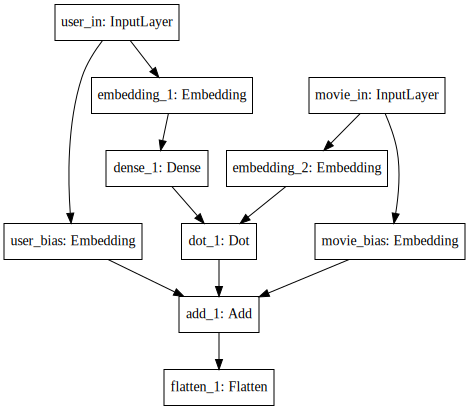

In [7]:
model = recommender_net()
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pydot
import graphviz
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [9]:
from sklearn.model_selection import train_test_split
train, valid, train_valid, test = {}, {}, {}, {}
(train_valid['users'], test['users'], train_valid['movies'], test['movies'],
 train_valid['ratings'], test['ratings']) = train_test_split(
     ratings.userId,
     ratings.movieId,
     ratings.rating,
     test_size=0.3,
     random_state=1234)
(train['users'], valid['users'], train['movies'], valid['movies'],
 train['ratings'], valid['ratings']) = train_test_split(
     train_valid['users'],
     train_valid['movies'],
     train_valid['ratings'],
     test_size=0.3,
     random_state=5678)

In [27]:
from yellowfin import YFOptimizer
from keras import optimizers

opts = {
    'sgd+clip': lambda: optimizers.SGD(clipvalue=1),
    'sgd+momentum+clip': lambda: optimizers.SGD(momentum=0.9, nesterov=True, clipvalue=1),
    'adam+clip': lambda: optimizers.Adam(clipvalue=1),
    'nadam+clip': lambda: optimizers.Nadam(clipvalue=1),
    'adamax+clip': lambda: optimizers.Adamax(clipvalue=1),
    'yellowfin+clip': lambda: optimizers.TFOptimizer(YFOptimizer(clip_thresh=1))
}

In [28]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [29]:
from keras.models import load_model
save_dir = '../models/movielens/'
import os.path
import keras_util
import keras

for optname, opt in opts.items():
    keras_util.refresh()
    print('*****', optname, '*****')
    if os.path.isfile(save_dir + optname + '-hist'):
        print('already done, skipping')
        continue
    net = recommender_net()
    net.compile(loss='mse', optimizer=opt())
    tb = keras.callbacks.TensorBoard(log_dir='../models/logs/' + optname)
    checkpoint = keras.callbacks.ModelCheckpoint(
        save_dir + optname + '-net',
        monitor='val_loss',
        save_best_only=True)
    with keras_util.rectime():
        hist = net.fit(
            [train['users'], train['movies']],
            train['ratings'],
                epochs=100,
                batch_size=200000,
                callbacks=[checkpoint, tb],
                validation_data=([valid['users'], valid['movies']],
                                 valid['ratings']))
    save_object(hist.history, save_dir + optname + '-hist')

***** yellowfin+clip *****
already done, skipping
***** adamax+clip *****
Train on 9800128 samples, validate on 4200056 samples
Epoch 1/100
9800128/9800128 [==============================] - 11s - loss: 11.8815 - val_loss: 7.0872
Epoch 2/100
9800128/9800128 [==============================] - 13s - loss: 2.5079 - val_loss: 1.0782
Epoch 3/100
9800128/9800128 [==============================] - 13s - loss: 0.9101 - val_loss: 0.8492
Epoch 4/100
9800128/9800128 [==============================] - 13s - loss: 0.8039 - val_loss: 0.8031
Epoch 5/100
9800128/9800128 [==============================] - 13s - loss: 0.7758 - val_loss: 0.7863
Epoch 6/100
9800128/9800128 [==============================] - 13s - loss: 0.7640 - val_loss: 0.7783
Epoch 7/100
9800128/9800128 [==============================] - 13s - loss: 0.7577 - val_loss: 0.7736
Epoch 8/100
9800128/9800128 [==============================] - 13s - loss: 0.7536 - val_loss: 0.7706
Epoch 9/100
9800128/9800128 [==============================] - 

9800128/9800128 [==============================] - 10s - loss: 0.5738 - val_loss: 0.7210
Epoch 81/100
9800128/9800128 [==============================] - 10s - loss: 0.5697 - val_loss: 0.7214
Epoch 82/100
9800128/9800128 [==============================] - 10s - loss: 0.5657 - val_loss: 0.7219
Epoch 83/100
9800128/9800128 [==============================] - 10s - loss: 0.5617 - val_loss: 0.7224
Epoch 84/100
9800128/9800128 [==============================] - 10s - loss: 0.5577 - val_loss: 0.7230
Epoch 85/100
9800128/9800128 [==============================] - 10s - loss: 0.5537 - val_loss: 0.7236
Epoch 86/100
9800128/9800128 [==============================] - 10s - loss: 0.5498 - val_loss: 0.7243
Epoch 87/100
9800128/9800128 [==============================] - 10s - loss: 0.5459 - val_loss: 0.7250
Epoch 88/100
9800128/9800128 [==============================] - 10s - loss: 0.5419 - val_loss: 0.7257
Epoch 89/100
9800128/9800128 [==============================] - 10s - loss: 0.5380 - val_loss: 

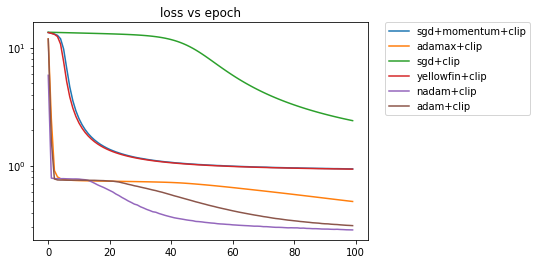

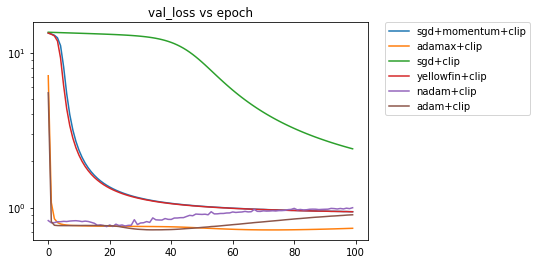

In [31]:
import os
save_dir = '../models/movielens/'

for losstype in ['loss', 'val_loss']:
    for filename in os.listdir(save_dir):
        if filename.endswith('-hist'):
            opt = filename[:-5]
            hist = load_object(save_dir + filename)[losstype]
            plt.semilogy(hist, label=opt)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0.)
    plt.title(losstype + ' vs epoch')
    plt.show()

In [32]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/gpu:0', '/gpu:1']